In this notebook we plot the results of the experiments for the following parameters:
 - linear model
 - wind fields as part of the predictors
 - no gradients as part of the predictors
 - PCA caculated using all rows and columns
 
 The notebook was run with 

# Experiments config

In a attempt to make things clearer, here is a copy of the experiments config/code:

# Plots

Here the results aIn a attempt to make things clearer, here is a copy of the experiments config/code:re plotted using a copy of the code that was in the repository

In [1]:
# basics
import os, sys

# arrays
import numpy as np
import xarray as xr

# application
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import panel as pn

pn.extension()

# to autocomplete code
%config Completer.use_jedi = False

# append sscode to path
#sys.path.insert(0, os.path.join(os.path.abspath(''), '..'))
sys.path.insert(0, '/home/metocean/geocean-nz-ss')
data_path = '/data' #'/data/storm_surge_data/'
os.environ["SSURGE_DATA_PATH"] = data_path
default_region=(140,190,-70,-20)
default_region_reduced = (160,185,-52,-30)

from sscode.config import default_region_reduced
from sscode.plotting.config import _figsize, _fontsize_title
from sscode.plotting.utils import plot_ccrs_nz
from sscode.data import load_moana_hindcast

# from bokeh.plotting import figure, show, output_notebook
# output_notebook()

%matplotlib inline

DATA PATH /data


In [2]:
linear_stats = xr.open_dataset('../../data/statistics/experiments/ahanoa2_winds_and_gradient_experiment_linear_final_args.nc')

In [3]:
linear_stats

<xarray.Dataset>
Dimensions:      (site: 29, grad: 1, winds: 1, tlapse: 3, tresample: 3, region: 3, tsize: 1, perpcs: 1)
Coordinates:
  * site         (site) int64 116 200 224 328 378 ... 1217 1260 1296 1327 1442
Dimensions without coordinates: grad, winds, tlapse, tresample, region, tsize, perpcs
Data variables: (12/16)
    expl_var     (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    mae          (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    mse          (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    me           (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    medae        (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    tweedie      (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    ...           ...
    bias         (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    si           (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    rmse         (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    pearson      (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    spearman     (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    rscore       (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...

In [4]:
stats_plot = linear_stats # EDIT TO PLOT KNN

# generate labels for x-axis
variables_dictionary = {
    'calculate_gradient': ['GrT'],
    'winds': ['WT'],
    'time_lapse': ['TL1','TL2','TL3'],
    'time_resample': ['6H','12H','1D'],
    'region': ['local_2.1', 'local_4.1', 'NZ'],
    'train_size': ['70%'],
    'percentage_pcs': ['98%'],
    'k_neighbors': ['3','6','9']
}

x_labels = []

for cg in variables_dictionary['calculate_gradient']:
    for ws in variables_dictionary['winds']:
        for tl in variables_dictionary['time_lapse']:
            for tr in variables_dictionary['time_resample']:
                for r in variables_dictionary['region']:
                    for ts in variables_dictionary['train_size']:
                        for pp in variables_dictionary['percentage_pcs']:
                            # for kn in variables_dictionary['k_neighbors']:
                            x_labels.append(
                                cg+' - '+tl+' - '+tr+' - '+r+' - ' # +kn
                            )

In [5]:
# and now we load the longitudes and latitudes for the selected sites
locations = load_moana_hindcast(plot=False)[['lon','lat']].sel(site=linear_stats.site.values)
# select colors for each location depending on the shore


 loading the Moana v2 hindcast data... 



In [6]:
locations

<xarray.Dataset>
Dimensions:  (site: 29)
Coordinates:
  * site     (site) int64 116 200 224 328 378 393 ... 1217 1260 1296 1327 1442
Data variables:
    lon      (site) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    lat      (site) float64 dask.array<chunksize=(1,), meta=np.ndarray>

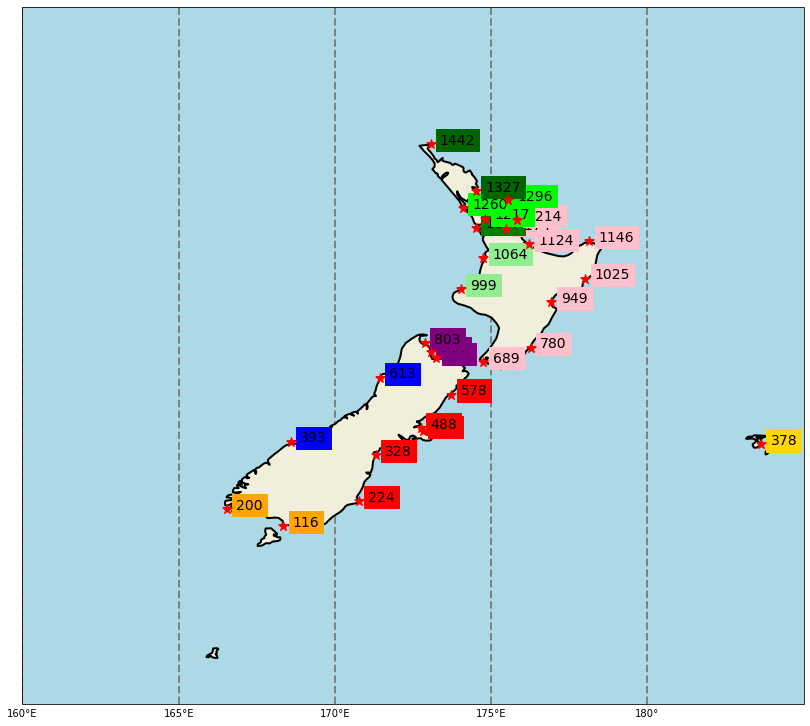

In [7]:
# select colors for each location depending on the shore
locations_colors = [
    'orange','orange','red','red','gold','blue','red','red','red','blue','pink',
    'purple','purple','pink','purple','pink','lightgreen','pink','lightgreen','pink','pink','pink',
    'green','pink','lime','lime','lime','darkgreen','darkgreen'
]
# plot all the locations with the colors
# %matplotlib to zoom in the map
fig, ax = plt.subplots(
    figsize=(14,14),subplot_kw={
        'projection':ccrs.PlateCarree(central_longitude=180)
    }
)
xr.plot.scatter(
    locations,x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(),
    zorder=50,s=100,marker='*',c='red'
)
for isite,color in zip(range(len(locations.site)),locations_colors):
    ax.text(
        x=locations.lon.values[isite]+0.3,y=locations.lat.values[isite],
        s=locations.site.values.astype(str)[isite],
        transform=ccrs.PlateCarree(),size=14,zorder=40,
        backgroundcolor=color
    )
plot_ccrs_nz([ax],plot_labels=(True,5,5))
ax.set_facecolor('lightblue')

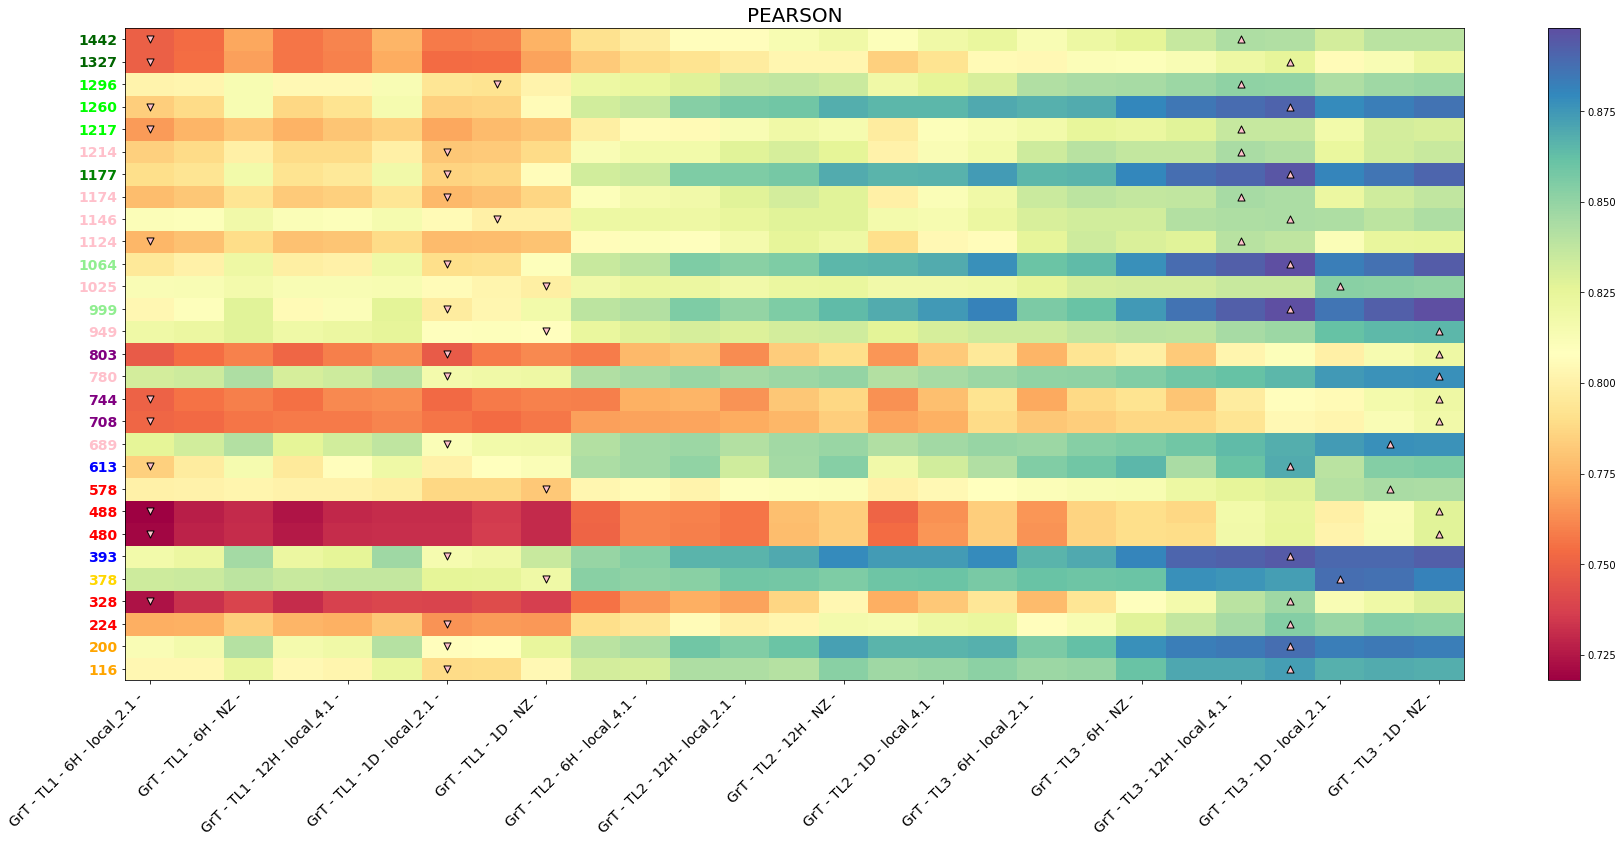

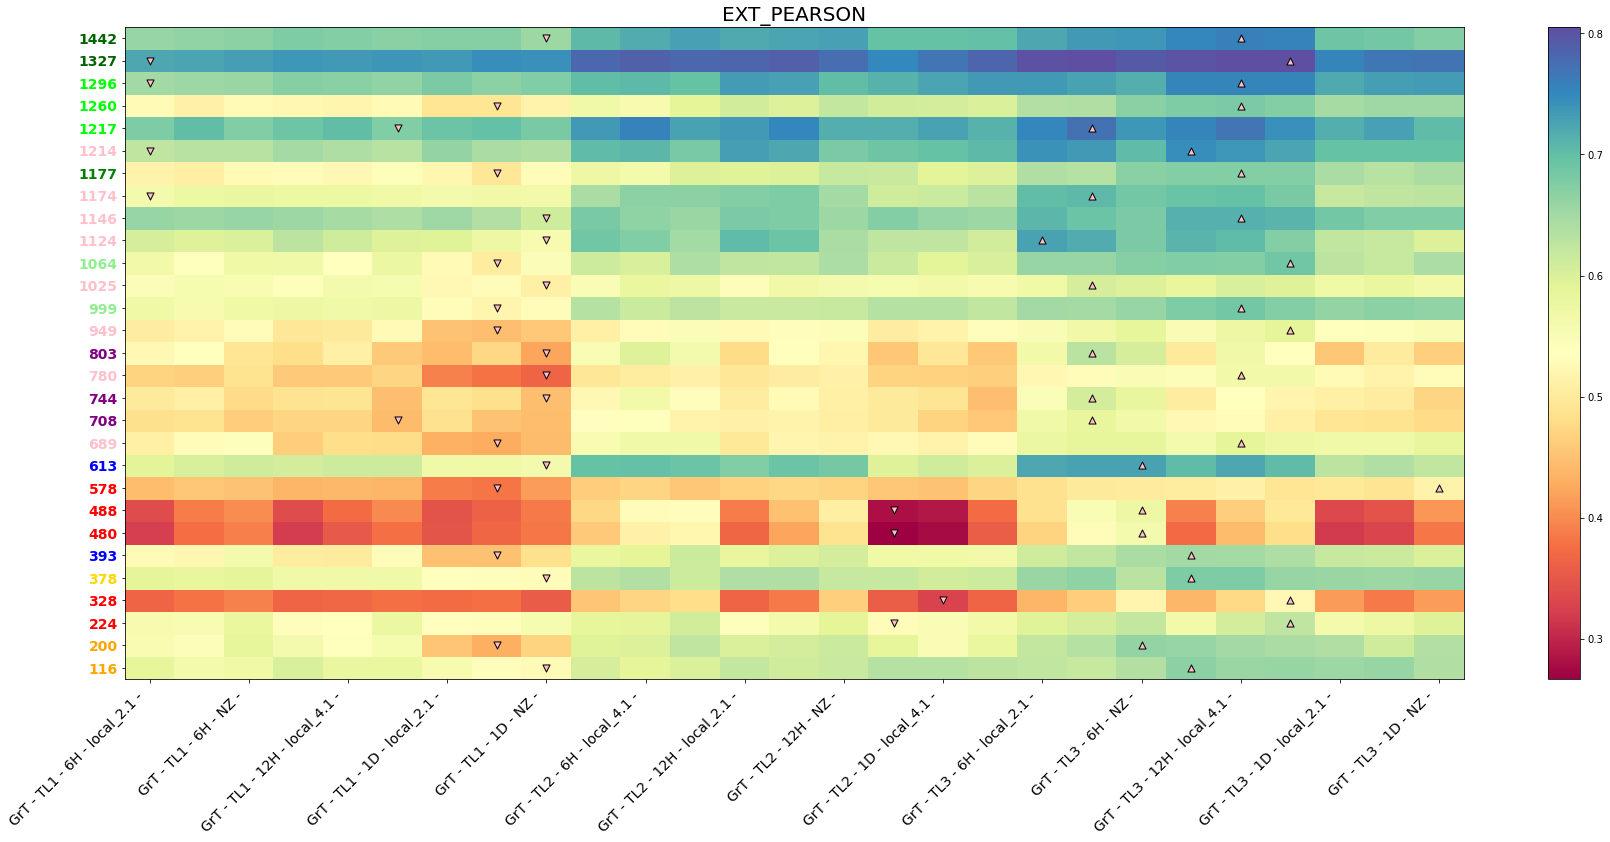

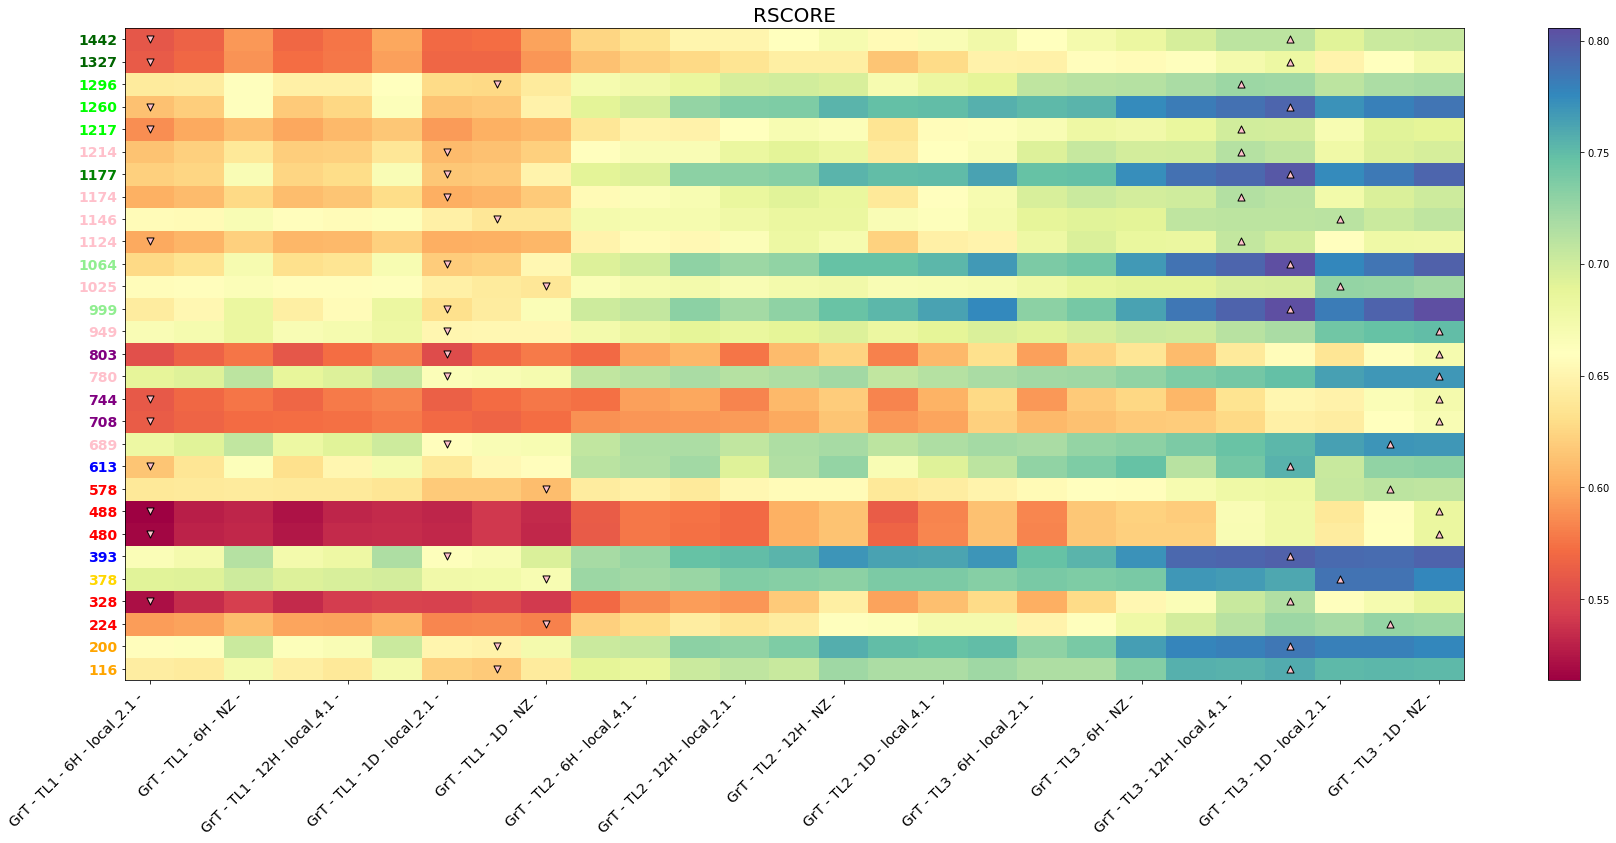

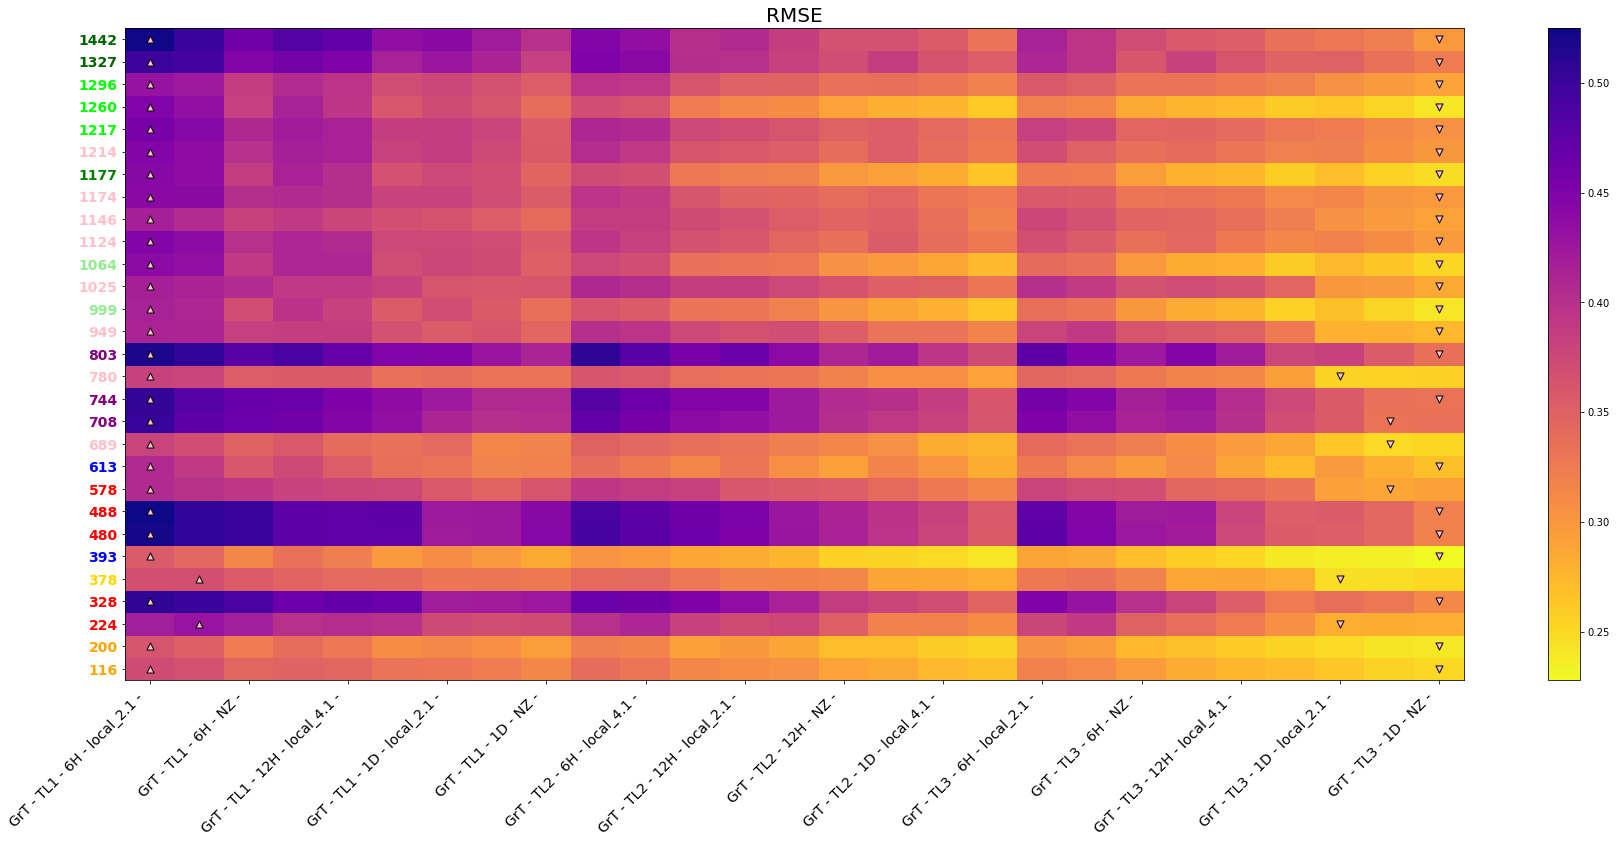

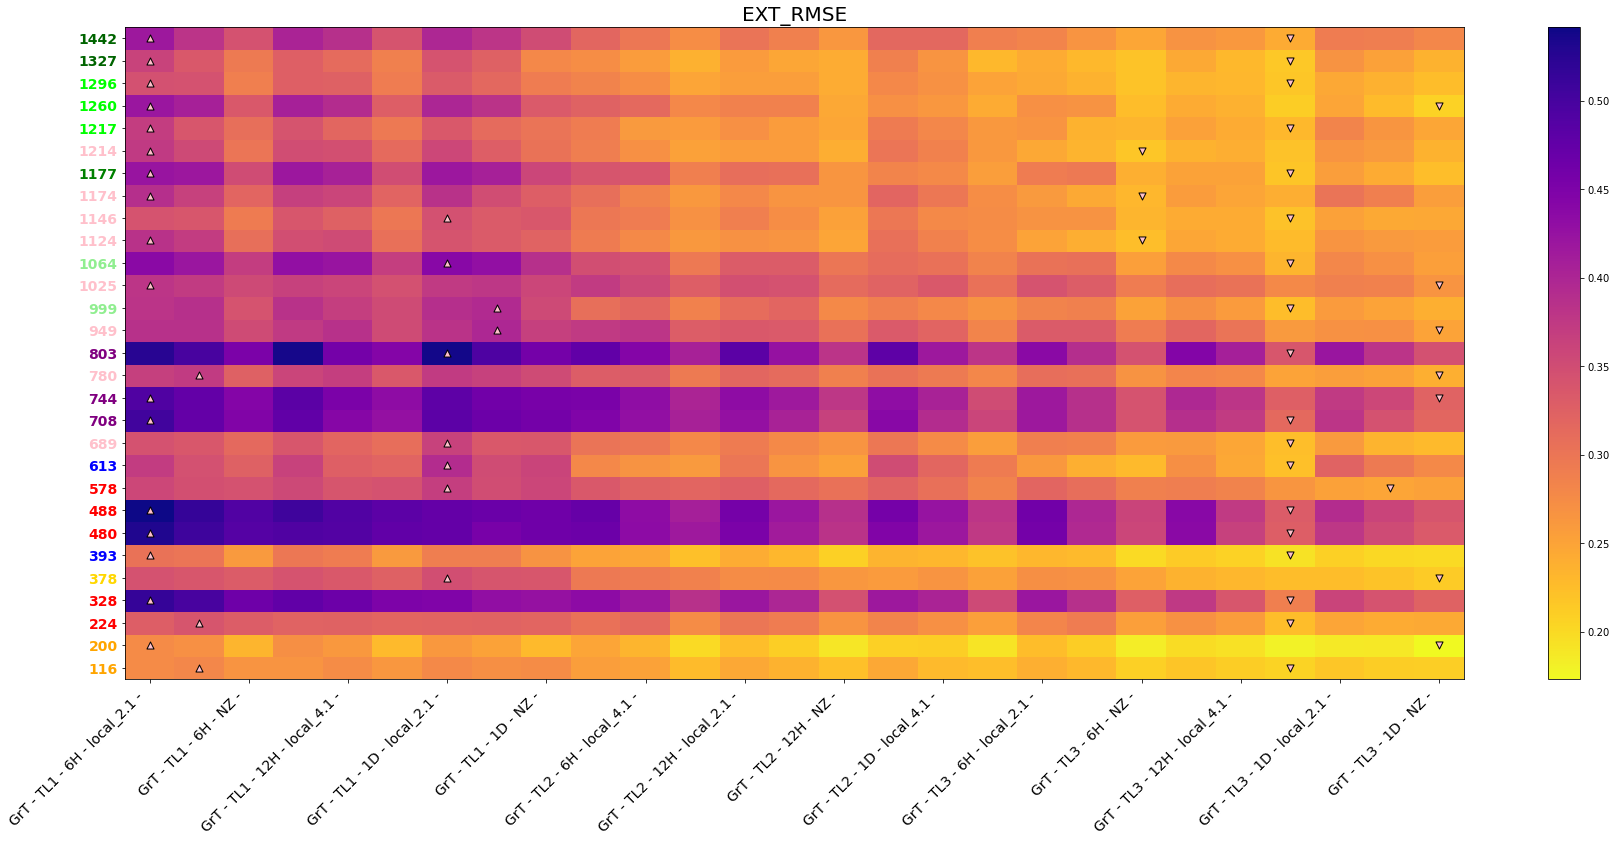

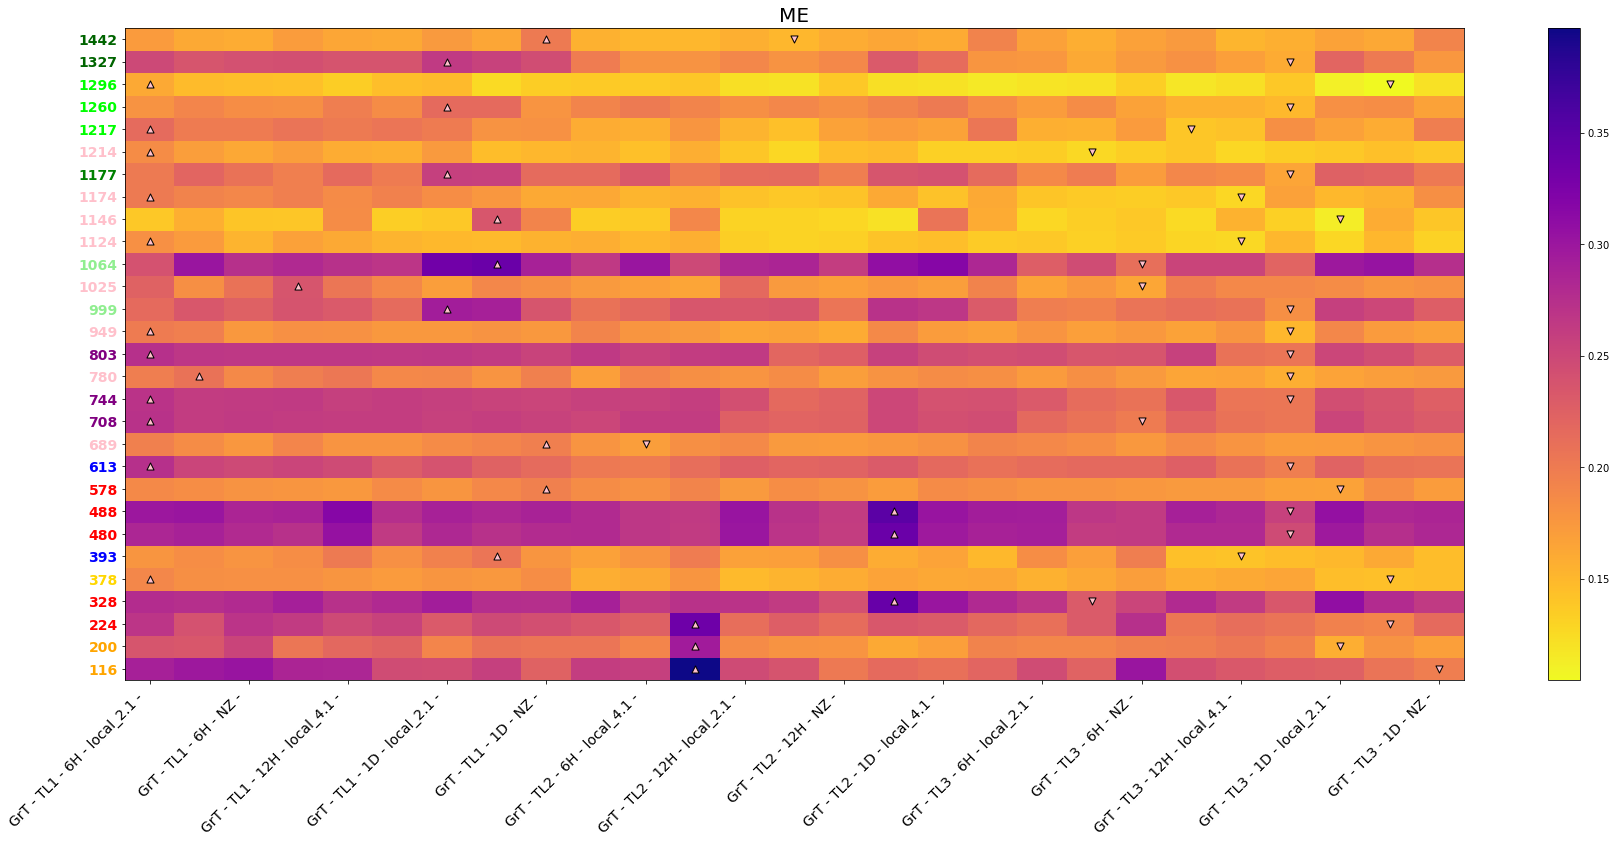

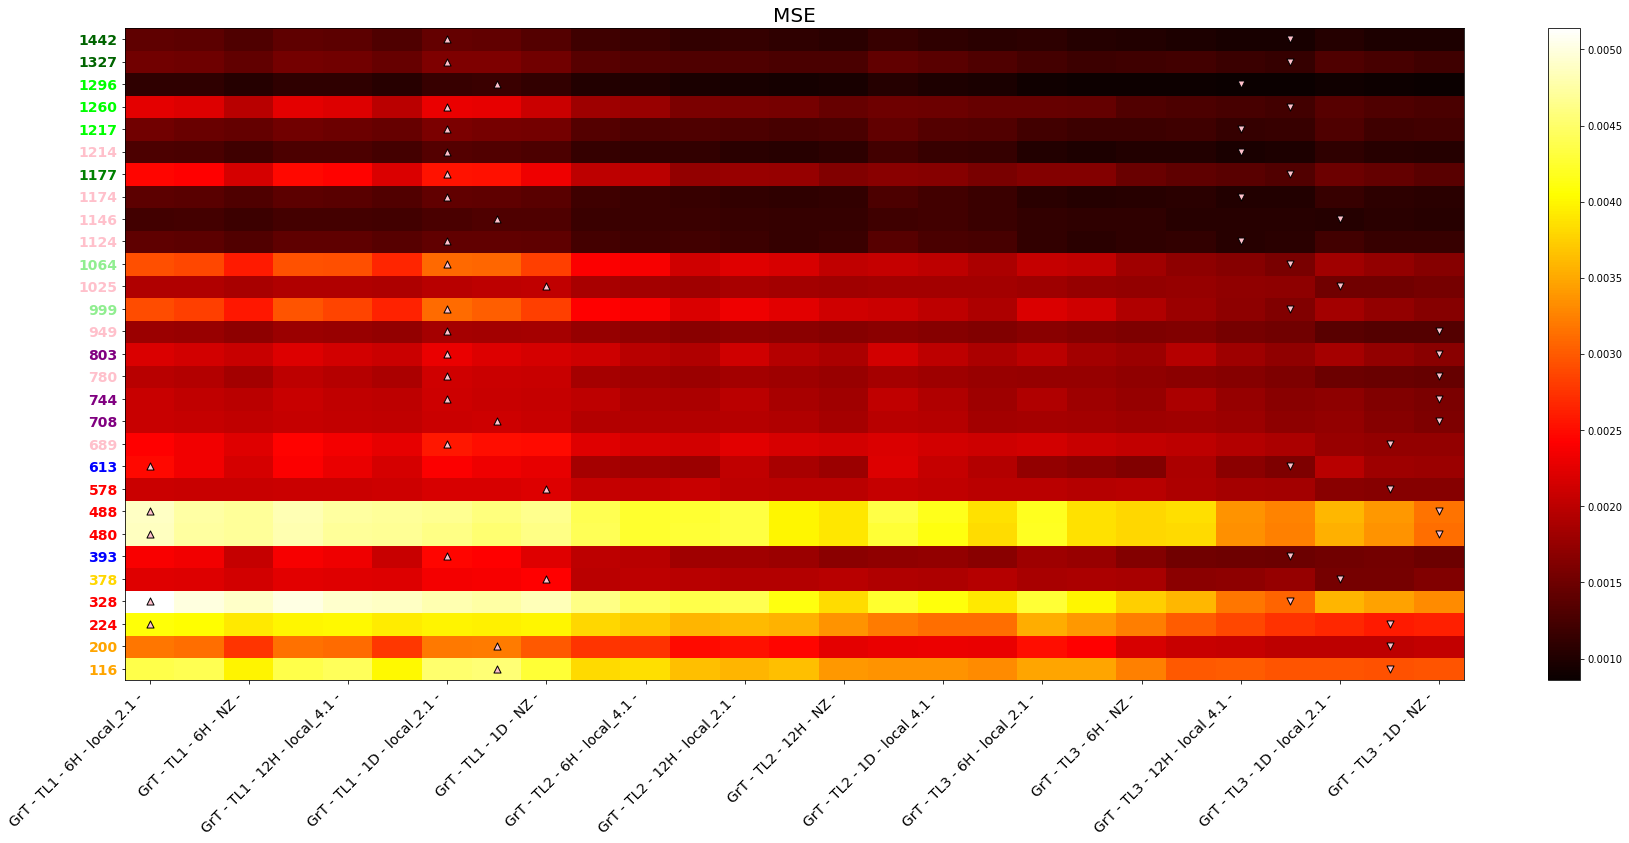

In [8]:
metrics_cmaps = { # ascendig = True
    'expl_var': 'Spectral', 'me': 'plasma_r', 'mae': 'hot', 'mse': 'hot', 'ext_rmse': 'plasma_r',
    'medae': 'hot', 'tweedie': 'jet', 'bias': 'pink_r', 'si': 'Spectral_r',
    'rmse': 'plasma_r', 'pearson': 'Spectral', 'spearman': 'jet', 'rscore': 'Spectral',
    'ext_pearson': 'Spectral'
}

# extract best sites order
num_sites = len(stats_plot.site)
sites_order = np.argsort(
    np.mean(stats_plot['pearson'].values.reshape(num_sites,-1),axis=1)
) # this is not used
    
for metric_to_plot in ['pearson','ext_pearson','rscore','rmse','ext_rmse','me','mse']:
    fig, ax = plt.subplots(figsize=(30,12))
    # extract metric values from xarray.Dataset
    metric_values = stats_plot[metric_to_plot].values.reshape(num_sites,-1)[:,:] \
        if metric_to_plot!='bias' else np.abs(
            stats_plot[metric_to_plot].values.reshape(num_sites,-1)[:,:]
        )
    # plot pcolors 
    pc = ax.pcolor(
        metric_values, cmap=metrics_cmaps[metric_to_plot],
        vmin=np.nanmin(metric_values),vmax=np.nanmax(metric_values)
    )
    ax.scatter(
        np.argsort(metric_values)[:,0].reshape(-1) + 0.5, # last values in array
        np.repeat(np.arange(num_sites),1) + 0.5, # y_positons
        marker='v',facecolors='pink',edgecolors='black',linewidth=1,s=50,
        zorder=10
    )
    ax.scatter(
        np.argsort(metric_values)[:,-1].reshape(-1) + 0.5, # last values in array
        np.repeat(np.arange(num_sites),1) + 0.5, # y_positons
        marker='^',facecolors='pink',edgecolors='black',linewidth=1,s=50,
        zorder=10
    )
    # plot vertical lines to help eye
    # ax.axvline(x=62.5,linewidth=2,linestyle='--',c='grey')
    # ax.axvline(x=71.5,linewidth=2,linestyle='--',c='grey')
    fig.colorbar(pc,ax=ax)
    ax.set_yticks(np.arange(num_sites)+0.5) # these are the positions, and below the labels = sites
    ax.set_yticklabels(stats_plot.site.values[:],fontweight='bold',fontsize=14)
    for ytick,color in zip(ax.get_yticklabels(),locations_colors):
        ytick.set_color(color)
    ax.set_xticks(np.arange(0,metric_values.shape[1],2)+0.5)
    ax.set_xticklabels(x_labels[::2],fontsize=14)
    plt.setp(ax.get_xticklabels(),rotation=45,ha='right')
    ax.set_title(metric_to_plot.upper(),fontsize=20)